In [17]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

PATH_to_log_dir = '/data/cv_final/CT-Predict/3D-Seg/result' # 如果输出路径不存在会被自动创建
writer = SummaryWriter(PATH_to_log_dir)

# for n_iter in range(100):
#     writer.add_scalar('Loss/train', np.random.random(), n_iter)
#     writer.add_scalar('Accuracy/train', np.random.random(), n_iter)

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image

torch.cuda.empty_cache()

In [19]:
train_transformer = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

val_transformer = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision

import numpy as np
import pandas as pd

from pathlib import Path

batchsize=4
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class VolumeDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, volume_size= 4, transform=None):
        super(VolumeDataset, self).__init__()
        
        self._cube_dir = Path(root_dir)
        self._paths = []
        self._labels = []
        self.volume_depth = volume_size
        
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['COVID19', 'Normal']
        self.num_cls = len(self.classes)
        one_class_path = []
        one_class_laebl = []
        for c in range(self.num_cls):
            one_class_path = read_txt(self.txt_path[c])
            one_class_label = [c] * len(one_class_path) 
            self._paths += one_class_path
            self._labels += one_class_label
        
        
    def _load_cube(self, filepath):
        vol = np.load(filepath)
        # file shape: (volume_size, H, W) 
        vol = torch.tensor(vol, dtype=torch.float)
        vol = vol.permute(3,0,1,2) # to (C,D,H,W)
        return vol


    def _get_cube(self, filepath):
        vol = self._load_cube(filepath)
#         print(vol)
        return vol


    def __len__(self):
#         print('len')
        return len(self._paths)


    def __getitem__(self, idx):
#         print(idx)
        path = self._paths[idx]
        label = self._labels[idx]
        x = self._get_cube(path)
#         print(x)
        y = label
        return x, y
    

In [20]:
if __name__ == '__main__':
    trainset = VolumeDataset(root_dir='/data/Data/3D',
                              txt_COVID='/data/Data/3D/Data_split/COVID19/COVID19_train.txt',
                              txt_NonCOVID='/data/Data/3D/Data_split/Normal/Normal_train.txt')
    valset = VolumeDataset(root_dir='/data/Data3D/',
                              txt_COVID='/data/Data/3D/Data_split/COVID19/COVID19_val.txt',
                              txt_NonCOVID='/data/Data/3D/Data_split/Normal/Normal_val.txt')
    testset = VolumeDataset(root_dir='/data/Data3D/',
                              txt_COVID='/data/Data/3D/Data_split/COVID19/COVID19_test.txt',
                              txt_NonCOVID='/data/Data/3D/Data_split/Normal/Normal_test.txt')
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

349
99
51


In [21]:
for b,l in trainset:
    print(b.shape, l)
    break

torch.Size([3, 4, 512, 512]) 0


In [22]:
"""Load Self-Trans model"""
"""Change names and locations to the Self-Trans.pt"""

# from resnet3d import resnet3d18 as renet
# import resnet3d 
from resnet3d  import resnet3d18 as resnet18
model = resnet18()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = model.to(device)

modelname = '3DResNet'

In [23]:
his = {}
his['train_loss'] = []
his['train_acc'] = []
his['val_loss'] = []
his['val_acc'] = []
his['test_loss'] = []
his['test_acc'] = []


In [24]:
#training process is defined here 

alpha = None
## alpha is None if mixup is not used
alpha_name = f'{alpha}'
device = 'cuda'

def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
        
        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    
    # 记录一个epoch的总loss和batch的平均acc
    avg_loss = train_loss/len(train_loader.dataset)
    avg_acc = train_correct / len(train_loader.dataset)
    
#     writer.add_scalar('Loss/train', avg_loss, epoch)
#     writer.add_scalar('Accuracy/train', avg_acc, epoch)

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, train_correct, len(train_loader.dataset),
        avg_acc))
    his['train_loss'].append(train_loss.data.cpu().numpy()/ len(train_loader.dataset))
    his['train_acc'].append(train_correct / len(train_loader.dataset))
    f = open('/data/cv_final/CT-Predict/3D-Seg/result/{}.txt'.format(modelname), 'a+')
    f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, train_correct, len(train_loader.dataset),
        avg_acc))
    f.write('\n')
    f.close()

In [25]:
#val process is defined here

def val(epoch):
    
    model.eval()
    val_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, (data, target) in enumerate(val_loader):
            print('batch_index:\t', batch_index)
            data, target = data.to(device), target.to(device)

            
            output = model(data)
            
            val_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
    
    # 记录一个epoch的loss, acc
    his['val_loss'].append(val_loss.data.cpu().numpy()/len(val_loader.dataset))
    his['val_acc'].append(correct/len(val_loader.dataset))

    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [ ]:
import datetime
# train
bs = batchsize
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr) 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
best_acc = 0
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 50
for epoch in range(1, total_epoch+1):
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum

        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()


        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)

        
        
#         if epoch == total_epoch:
        if best_acc < acc:
            best_acc = acc
            torch.save(model.state_dict(), "/data/cv_final/CT-Predict/3D-Seg/result/{}_{}_{}_{}.pt".format(modelname,alpha_name,epoch, datetime.datetime.now()))  

            vote_pred = np.zeros(valset.__len__())
            vote_score = np.zeros(valset.__len__())
            print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
    average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
            epoch, r, p, F1, acc, AUC))

            f = open('/data/cv_final/CT-Predict/3D-Seg/result/{}_{}_{}_{}.txt'.format(modelname,alpha_name, epoch,lr), 'a+')
            f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
    average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
            epoch, r, p, F1, acc, AUC))
            f.close()



Train Epoch: 1 [0/88 (0%)]	Train Loss: 0.178571
Train Epoch: 1 [4/88 (5%)]	Train Loss: 0.012117
Train Epoch: 1 [8/88 (9%)]	Train Loss: 0.184390
Train Epoch: 1 [12/88 (14%)]	Train Loss: 0.199516
Train Epoch: 1 [16/88 (18%)]	Train Loss: 0.065555
Train Epoch: 1 [20/88 (23%)]	Train Loss: 0.152092
Train Epoch: 1 [24/88 (27%)]	Train Loss: 0.133089
Train Epoch: 1 [28/88 (32%)]	Train Loss: 0.031986
Train Epoch: 1 [32/88 (36%)]	Train Loss: 0.107577
Train Epoch: 1 [36/88 (41%)]	Train Loss: 0.033044
Train Epoch: 1 [40/88 (45%)]	Train Loss: 0.084500
Train Epoch: 1 [44/88 (50%)]	Train Loss: 0.086891
Train Epoch: 1 [48/88 (55%)]	Train Loss: 0.038149
Train Epoch: 1 [52/88 (59%)]	Train Loss: 0.013664
Train Epoch: 1 [56/88 (64%)]	Train Loss: 0.174366
Train Epoch: 1 [60/88 (68%)]	Train Loss: 0.017874
Train Epoch: 1 [64/88 (73%)]	Train Loss: 0.204565
Train Epoch: 1 [68/88 (77%)]	Train Loss: 0.007581
Train Epoch: 1 [72/88 (82%)]	Train Loss: 0.030086
Train Epoch: 1 [76/88 (86%)]	Train Loss: 0.010154
Train 

Train Epoch: 4 [0/88 (0%)]	Train Loss: 0.024498
Train Epoch: 4 [4/88 (5%)]	Train Loss: 0.005280
Train Epoch: 4 [8/88 (9%)]	Train Loss: 0.128571
Train Epoch: 4 [12/88 (14%)]	Train Loss: 0.005471
Train Epoch: 4 [16/88 (18%)]	Train Loss: 0.107847
Train Epoch: 4 [20/88 (23%)]	Train Loss: 0.071840
Train Epoch: 4 [24/88 (27%)]	Train Loss: 0.023133
Train Epoch: 4 [28/88 (32%)]	Train Loss: 0.016769
Train Epoch: 4 [32/88 (36%)]	Train Loss: 0.038415
Train Epoch: 4 [36/88 (41%)]	Train Loss: 0.004119
Train Epoch: 4 [40/88 (45%)]	Train Loss: 0.028589
Train Epoch: 4 [44/88 (50%)]	Train Loss: 0.005102
Train Epoch: 4 [48/88 (55%)]	Train Loss: 0.022864
Train Epoch: 4 [52/88 (59%)]	Train Loss: 0.027420
Train Epoch: 4 [56/88 (64%)]	Train Loss: 0.005387
Train Epoch: 4 [60/88 (68%)]	Train Loss: 0.057855
Train Epoch: 4 [64/88 (73%)]	Train Loss: 0.001062
Train Epoch: 4 [68/88 (77%)]	Train Loss: 0.003651
Train Epoch: 4 [72/88 (82%)]	Train Loss: 0.014544
Train Epoch: 4 [76/88 (86%)]	Train Loss: 0.009863
Train 

Train Epoch: 7 [0/88 (0%)]	Train Loss: 0.001543
Train Epoch: 7 [4/88 (5%)]	Train Loss: 0.000532
Train Epoch: 7 [8/88 (9%)]	Train Loss: 0.003380
Train Epoch: 7 [12/88 (14%)]	Train Loss: 0.006972
Train Epoch: 7 [16/88 (18%)]	Train Loss: 0.003728
Train Epoch: 7 [20/88 (23%)]	Train Loss: 0.004215
Train Epoch: 7 [24/88 (27%)]	Train Loss: 0.088407
Train Epoch: 7 [28/88 (32%)]	Train Loss: 0.003681
Train Epoch: 7 [32/88 (36%)]	Train Loss: 0.002712
Train Epoch: 7 [36/88 (41%)]	Train Loss: 0.026348
Train Epoch: 7 [40/88 (45%)]	Train Loss: 0.007192
Train Epoch: 7 [44/88 (50%)]	Train Loss: 0.001243
Train Epoch: 7 [48/88 (55%)]	Train Loss: 0.013738
Train Epoch: 7 [52/88 (59%)]	Train Loss: 0.004972
Train Epoch: 7 [56/88 (64%)]	Train Loss: 0.001732
Train Epoch: 7 [60/88 (68%)]	Train Loss: 0.017479
Train Epoch: 7 [64/88 (73%)]	Train Loss: 0.014334
Train Epoch: 7 [68/88 (77%)]	Train Loss: 0.018025
Train Epoch: 7 [72/88 (82%)]	Train Loss: 0.008071
Train Epoch: 7 [76/88 (86%)]	Train Loss: 0.006457
Train 

Train Epoch: 10 [0/88 (0%)]	Train Loss: 0.000826
Train Epoch: 10 [4/88 (5%)]	Train Loss: 0.000736
Train Epoch: 10 [8/88 (9%)]	Train Loss: 0.003476
Train Epoch: 10 [12/88 (14%)]	Train Loss: 0.084082
Train Epoch: 10 [16/88 (18%)]	Train Loss: 0.013517
Train Epoch: 10 [20/88 (23%)]	Train Loss: 0.042206
Train Epoch: 10 [24/88 (27%)]	Train Loss: 0.004164
Train Epoch: 10 [28/88 (32%)]	Train Loss: 0.002868
Train Epoch: 10 [32/88 (36%)]	Train Loss: 0.000270
Train Epoch: 10 [36/88 (41%)]	Train Loss: 0.044071
Train Epoch: 10 [40/88 (45%)]	Train Loss: 0.001257
Train Epoch: 10 [44/88 (50%)]	Train Loss: 0.060100
Train Epoch: 10 [48/88 (55%)]	Train Loss: 0.001026
Train Epoch: 10 [52/88 (59%)]	Train Loss: 0.000461
Train Epoch: 10 [56/88 (64%)]	Train Loss: 0.003732
Train Epoch: 10 [60/88 (68%)]	Train Loss: 0.225610
Train Epoch: 10 [64/88 (73%)]	Train Loss: 0.013544
Train Epoch: 10 [68/88 (77%)]	Train Loss: 0.049394
Train Epoch: 10 [72/88 (82%)]	Train Loss: 0.013200
Train Epoch: 10 [76/88 (86%)]	Train L

Train Epoch: 12 [56/88 (64%)]	Train Loss: 0.003290
Train Epoch: 12 [60/88 (68%)]	Train Loss: 0.009828
Train Epoch: 12 [64/88 (73%)]	Train Loss: 0.003884
Train Epoch: 12 [68/88 (77%)]	Train Loss: 0.001348
Train Epoch: 12 [72/88 (82%)]	Train Loss: 0.178064
Train Epoch: 12 [76/88 (86%)]	Train Loss: 0.000746
Train Epoch: 12 [80/88 (91%)]	Train Loss: 0.168676
Train Epoch: 12 [84/88 (95%)]	Train Loss: 0.000844

Train set: Average loss: 0.0111, Accuracy: 344/349 (1%)

batch_index:	 0
batch_index:	 1
batch_index:	 2
batch_index:	 3
batch_index:	 4
batch_index:	 5
batch_index:	 6
batch_index:	 7
batch_index:	 8
batch_index:	 9
batch_index:	 10
batch_index:	 11
batch_index:	 12
batch_index:	 13
batch_index:	 14
batch_index:	 15
batch_index:	 16
batch_index:	 17
batch_index:	 18
batch_index:	 19
batch_index:	 20
batch_index:	 21
batch_index:	 22
batch_index:	 23
batch_index:	 24
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.

Train Epoch: 15 [0/88 (0%)]	Train Loss: 0.000258
Train Epoch: 15 [4/88 (5%)]	Train Loss: 0.000675
Train Epoch: 15 [8/88 (9%)]	Train Loss: 0.001315
Train Epoch: 15 [12/88 (14%)]	Train Loss: 0.000670
Train Epoch: 15 [16/88 (18%)]	Train Loss: 0.013478
Train Epoch: 15 [20/88 (23%)]	Train Loss: 0.013086
Train Epoch: 15 [24/88 (27%)]	Train Loss: 0.001257
Train Epoch: 15 [28/88 (32%)]	Train Loss: 0.000524
Train Epoch: 15 [32/88 (36%)]	Train Loss: 0.000345
Train Epoch: 15 [36/88 (41%)]	Train Loss: 0.002390
Train Epoch: 15 [40/88 (45%)]	Train Loss: 0.004004
Train Epoch: 15 [44/88 (50%)]	Train Loss: 0.000463
Train Epoch: 15 [48/88 (55%)]	Train Loss: 0.001111
Train Epoch: 15 [52/88 (59%)]	Train Loss: 0.000889
Train Epoch: 15 [56/88 (64%)]	Train Loss: 0.000397
Train Epoch: 15 [60/88 (68%)]	Train Loss: 0.001409
Train Epoch: 15 [64/88 (73%)]	Train Loss: 0.000570
Train Epoch: 15 [68/88 (77%)]	Train Loss: 0.000486
Train Epoch: 15 [72/88 (82%)]	Train Loss: 0.000598
Train Epoch: 15 [76/88 (86%)]	Train L

batch_index:	 23
batch_index:	 24
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [0.00161535 0.00164644 0.00151702 0.0030484  0.00143819 0.01632521
 0.00267959 0.00157653 0.00202824 0.00213164 0.00196806 0.00170397
 0.00175536 0.00168901 0.00296639 0.00174909 0.00817461 0.00554578
 0.00444487 0.00189772 0.002157   0.00136239 0.02719323 0.00724134
 0.00316481 0.00206128 0.00784538 0.00779276 0.00222657 0.00211427
 0.00163788 0.00255372 0.99936026 0.99919134 0.99849665 0.99742597
 0.99932349 0.99923253 0.99930906 0.99902022 0.99929285 0.99896455
 0.99928755 0.99792296 0.99877232 0.99936634 0.9983564  0.99933308
 0.99907219 0.9992606  0.99898225 0.99884295 0.99930334 0.99933571
 0.99932384 0.99926561 0.99897695 0.99936253 0.

Train Epoch: 20 [0/88 (0%)]	Train Loss: 0.000381
Train Epoch: 20 [4/88 (5%)]	Train Loss: 0.001049
Train Epoch: 20 [8/88 (9%)]	Train Loss: 0.055225
Train Epoch: 20 [12/88 (14%)]	Train Loss: 0.002664
Train Epoch: 20 [16/88 (18%)]	Train Loss: 0.002474
Train Epoch: 20 [20/88 (23%)]	Train Loss: 0.000354
Train Epoch: 20 [24/88 (27%)]	Train Loss: 0.000958
Train Epoch: 20 [28/88 (32%)]	Train Loss: 0.045996
Train Epoch: 20 [32/88 (36%)]	Train Loss: 0.000285
Train Epoch: 20 [36/88 (41%)]	Train Loss: 0.002038
Train Epoch: 20 [40/88 (45%)]	Train Loss: 0.000645
Train Epoch: 20 [44/88 (50%)]	Train Loss: 0.000289
Train Epoch: 20 [48/88 (55%)]	Train Loss: 0.002313
Train Epoch: 20 [52/88 (59%)]	Train Loss: 0.002433
Train Epoch: 20 [56/88 (64%)]	Train Loss: 0.000508
Train Epoch: 20 [60/88 (68%)]	Train Loss: 0.000476
Train Epoch: 20 [64/88 (73%)]	Train Loss: 0.071362
Train Epoch: 20 [68/88 (77%)]	Train Loss: 0.001667
Train Epoch: 20 [72/88 (82%)]	Train Loss: 0.017062
Train Epoch: 20 [76/88 (86%)]	Train L

Train Epoch: 22 [68/88 (77%)]	Train Loss: 0.000333
Train Epoch: 22 [72/88 (82%)]	Train Loss: 0.000363
Train Epoch: 22 [76/88 (86%)]	Train Loss: 0.002219
Train Epoch: 22 [80/88 (91%)]	Train Loss: 0.000185
Train Epoch: 22 [84/88 (95%)]	Train Loss: 0.000512

Train set: Average loss: 0.0068, Accuracy: 347/349 (1%)

batch_index:	 0
batch_index:	 1
batch_index:	 2
batch_index:	 3
batch_index:	 4
batch_index:	 5
batch_index:	 6
batch_index:	 7
batch_index:	 8
batch_index:	 9
batch_index:	 10
batch_index:	 11
batch_index:	 12
batch_index:	 13
batch_index:	 14
batch_index:	 15
batch_index:	 16
batch_index:	 17
batch_index:	 18
batch_index:	 19
batch_index:	 20
batch_index:	 21
batch_index:	 22
batch_index:	 23
batch_index:	 24
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

Train Epoch: 25 [0/88 (0%)]	Train Loss: 0.006607
Train Epoch: 25 [4/88 (5%)]	Train Loss: 0.057581
Train Epoch: 25 [8/88 (9%)]	Train Loss: 0.005086
Train Epoch: 25 [12/88 (14%)]	Train Loss: 0.003529
Train Epoch: 25 [16/88 (18%)]	Train Loss: 0.001551
Train Epoch: 25 [20/88 (23%)]	Train Loss: 0.000889
Train Epoch: 25 [24/88 (27%)]	Train Loss: 0.000550
Train Epoch: 25 [28/88 (32%)]	Train Loss: 0.000462
Train Epoch: 25 [32/88 (36%)]	Train Loss: 0.000254
Train Epoch: 25 [36/88 (41%)]	Train Loss: 0.133126
Train Epoch: 25 [40/88 (45%)]	Train Loss: 0.000822
Train Epoch: 25 [44/88 (50%)]	Train Loss: 0.003822
Train Epoch: 25 [48/88 (55%)]	Train Loss: 0.000918
Train Epoch: 25 [52/88 (59%)]	Train Loss: 0.047097
Train Epoch: 25 [56/88 (64%)]	Train Loss: 0.000766
Train Epoch: 25 [60/88 (68%)]	Train Loss: 0.001481
Train Epoch: 25 [64/88 (73%)]	Train Loss: 0.009564
Train Epoch: 25 [68/88 (77%)]	Train Loss: 0.000747
Train Epoch: 25 [72/88 (82%)]	Train Loss: 0.007065
Train Epoch: 25 [76/88 (86%)]	Train L

batch_index:	 23
batch_index:	 24
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [0.00156163 0.00171499 0.00179496 0.00440537 0.00150462 0.02024583
 0.0024004  0.00158142 0.00198229 0.00225635 0.00196222 0.00185361
 0.00182907 0.00168844 0.00374305 0.00185318 0.00501635 0.0051915
 0.00402884 0.00238495 0.00249894 0.00138978 0.02858124 0.00659714
 0.00439298 0.00251895 0.00455746 0.00573532 0.00213867 0.00239664
 0.00146565 0.00169332 0.99965727 0.99960667 0.99944073 0.99909461
 0.99967647 0.99962997 0.99967015 0.9995504  0.99967086 0.99952197
 0.99966359 0.99926335 0.99944359 0.9996624  0.99936467 0.9996562
 0.99958605 0.9996717  0.99955004 0.99951136 0.99963081 0.99967515
 0.99966347 0.99963546 0.99954247 0.99968147 0.99

Train Epoch: 30 [0/88 (0%)]	Train Loss: 0.093479
Train Epoch: 30 [4/88 (5%)]	Train Loss: 0.000348
Train Epoch: 30 [8/88 (9%)]	Train Loss: 0.098060
Train Epoch: 30 [12/88 (14%)]	Train Loss: 0.001639
Train Epoch: 30 [16/88 (18%)]	Train Loss: 0.000560
Train Epoch: 30 [20/88 (23%)]	Train Loss: 0.001051
Train Epoch: 30 [24/88 (27%)]	Train Loss: 0.000473
Train Epoch: 30 [28/88 (32%)]	Train Loss: 0.001404
Train Epoch: 30 [32/88 (36%)]	Train Loss: 0.004879
Train Epoch: 30 [36/88 (41%)]	Train Loss: 0.001095
Train Epoch: 30 [40/88 (45%)]	Train Loss: 0.000644
Train Epoch: 30 [44/88 (50%)]	Train Loss: 0.003915
Train Epoch: 30 [48/88 (55%)]	Train Loss: 0.008364
Train Epoch: 30 [52/88 (59%)]	Train Loss: 0.000354
Train Epoch: 30 [56/88 (64%)]	Train Loss: 0.000091
Train Epoch: 30 [60/88 (68%)]	Train Loss: 0.000822
Train Epoch: 30 [64/88 (73%)]	Train Loss: 0.000523
Train Epoch: 30 [68/88 (77%)]	Train Loss: 0.000961
Train Epoch: 30 [72/88 (82%)]	Train Loss: 0.000352
Train Epoch: 30 [76/88 (86%)]	Train L

Train Epoch: 32 [4/88 (5%)]	Train Loss: 0.143494
Train Epoch: 32 [8/88 (9%)]	Train Loss: 0.000242
Train Epoch: 32 [12/88 (14%)]	Train Loss: 0.127080
Train Epoch: 32 [16/88 (18%)]	Train Loss: 0.000290
Train Epoch: 32 [20/88 (23%)]	Train Loss: 0.031707
Train Epoch: 32 [24/88 (27%)]	Train Loss: 0.007832
Train Epoch: 32 [28/88 (32%)]	Train Loss: 0.002441
Train Epoch: 32 [32/88 (36%)]	Train Loss: 0.000579
Train Epoch: 32 [36/88 (41%)]	Train Loss: 0.003906
Train Epoch: 32 [40/88 (45%)]	Train Loss: 0.001155
Train Epoch: 32 [44/88 (50%)]	Train Loss: 0.002598
Train Epoch: 32 [48/88 (55%)]	Train Loss: 0.000519
Train Epoch: 32 [52/88 (59%)]	Train Loss: 0.006959
Train Epoch: 32 [56/88 (64%)]	Train Loss: 0.001319
Train Epoch: 32 [60/88 (68%)]	Train Loss: 0.107475
Train Epoch: 32 [64/88 (73%)]	Train Loss: 0.007142
Train Epoch: 32 [68/88 (77%)]	Train Loss: 0.010221
Train Epoch: 32 [72/88 (82%)]	Train Loss: 0.011269
Train Epoch: 32 [76/88 (86%)]	Train Loss: 0.000479
Train Epoch: 32 [80/88 (91%)]	Train

batch_index:	 2
batch_index:	 3
batch_index:	 4
batch_index:	 5
batch_index:	 6
batch_index:	 7
batch_index:	 8
batch_index:	 9
batch_index:	 10
batch_index:	 11
batch_index:	 12
batch_index:	 13
batch_index:	 14
batch_index:	 15
batch_index:	 16
batch_index:	 17
batch_index:	 18
batch_index:	 19
batch_index:	 20
batch_index:	 21
batch_index:	 22
batch_index:	 23
batch_index:	 24
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [1.09121238e-03 1.31587463e-03 1.23080378e-03 2.75200000e-03
 9.98165109e-04 3.68117355e-02 2.45004380e-03 1.10128068e-03
 1.35383604e-03 1.71623949e-03 1.21418503e-03 1.24339643e-03
 1.15154439e-03 1.12015649e-03 1.89461396e-03 1.43075665e-03
 6.82072435e-03 5.93891228e-03 3.24740796e-03 1.43286958e

In [ ]:
#test process is defined here 

def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
    
    # 记录一个epoch的loss, acc
    his['test_loss'].append(test_loss.data.cpu().numpy()/len(test_loader.dataset))
    his['test_acc'].append(correct/len(test_loader.dataset))

    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [ ]:
# test
import datetime
bs = 10
import warnings
warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())


targetlist, scorelist, predlist = test(epoch)
print('target',targetlist)
print('score',scorelist)
print('predict',predlist)
vote_pred = vote_pred + predlist 
vote_score = vote_score + scorelist 

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
print('precision',p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall',r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1',F1)
print('acc',acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)

# 记录多个epoch的平均值
# writer.add_scalar('F1/test', F1, epoch)
# writer.add_scalar('acc/test', acc, epoch)
# writer.add_scalar('racall/test', r, epoch)
# writer.add_scalar('precision/test', p, epoch)

save_p = os.path.join(PATH_to_log_dir, f'test_{modelname}_{alpha}_{epoch}_{datetime.datetime.now()}.txt')
f = open(save_p, 'a+')
f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
epoch, r, p, F1, acc, AUC))
f.close()
torch.save(model.state_dict(), "/data/cv_final/CT-Predict/3D-Seg/result/transfer_{}_{}_wuhan.pt".format(modelname,alpha_name))


In [28]:
writer.close()

[0.0851469285850197, 0.07077601304368508, 0.06386198901856868, 0.043822307641321744, 0.034708214352670574, 0.01999401158111485, 0.02613348264065718, 0.013969694645835199, 0.00983561075860928, 0.016297869149456735, 0.014113978191911321, 0.011058806689899083, 0.014750360417844232, 0.014795196773671148, 0.009764641267180784, 0.006449441855138216, 0.0073987228480997605, 0.010555313104886381, 0.007517648631317226, 0.0054459892917840735, 0.017965370057988646, 0.01027121721502703, 0.007401881040338117, 0.009943014571181682, 0.0070128434025455684, 0.010293184515398348, 0.007416893213048022, 0.011164747883050694, 0.006496638486583458, 0.007215221836778701]


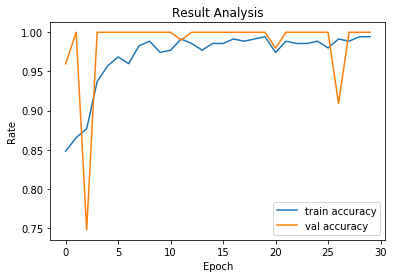

In [30]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#这里导入你自己的数据
#......
#......
#x_axix，train_pn_dis这些都是长度相同的list()
print(his['train_loss'])
x_axix = range(len(his['train_loss']))
#开始画图
sub_axix = filter(lambda x:x%200 == 0, x_axix)
plt.title('Result Analysis')
plt.plot(x_axix, his['train_acc'],  label='train accuracy')
plt.plot(x_axix, his['val_acc'], label='val accuracy')
# plt.plot(x_axix, his['train_loss'],  color='skyblue', label='train loss')
# plt.plot(x_axix, his['val_loss'], color='blue', label='val loss')
plt.legend() # 显示图例

plt.xlabel('Epoch')
plt.ylabel('Rate')
plt.show()
#python 一个折线图绘制多个曲线

In [ ]:
import pandas as pd
df = pd.DataFrame(his)
df.to_csv('/data/cv_final/CT-Predict/3D-Seg/result/his.csv')